# ***1. IMPORTS***

In [76]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional,Input, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re, string
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from collections import Counter
import nltk
from nltk import word_tokenize
nltk.download('punkt')
import torch
from transformers import AlbertTokenizer, AlbertConfig, AlbertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Munta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [77]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


# ***2. LOADING, EXPLORING, AND VISUALIZING THE DATASET***

In [107]:
url = 'train.csv'
df = pd.read_csv(url)
df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [80]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [81]:
print("\nMissing values in the dataset:")
print(df.isnull().sum())


Missing values in the dataset:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [82]:
print("\nDescriptive statistics of the target variable:")
print(df['target'].describe())


Descriptive statistics of the target variable:
count    7613.00000
mean        0.42966
std         0.49506
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: target, dtype: float64


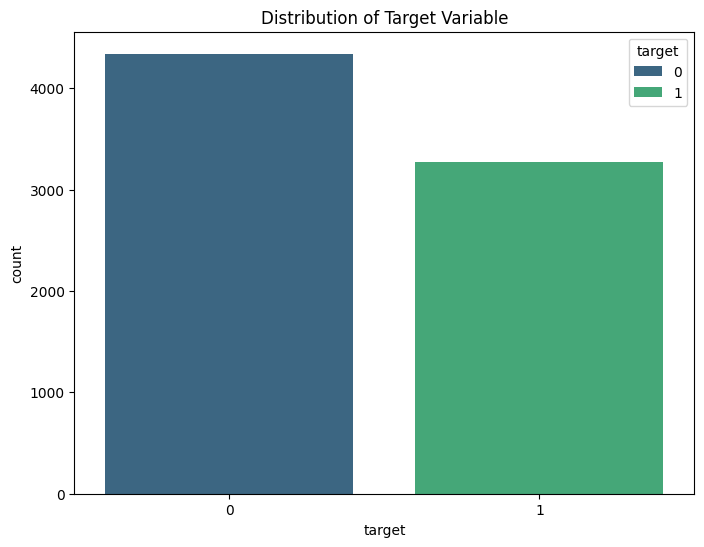

In [83]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', hue='target', data=df, palette='viridis', legend='auto')
plt.title('Distribution of Target Variable')
plt.show()

Max length: 31
Min length: 1
Average length: 14.903585971364771



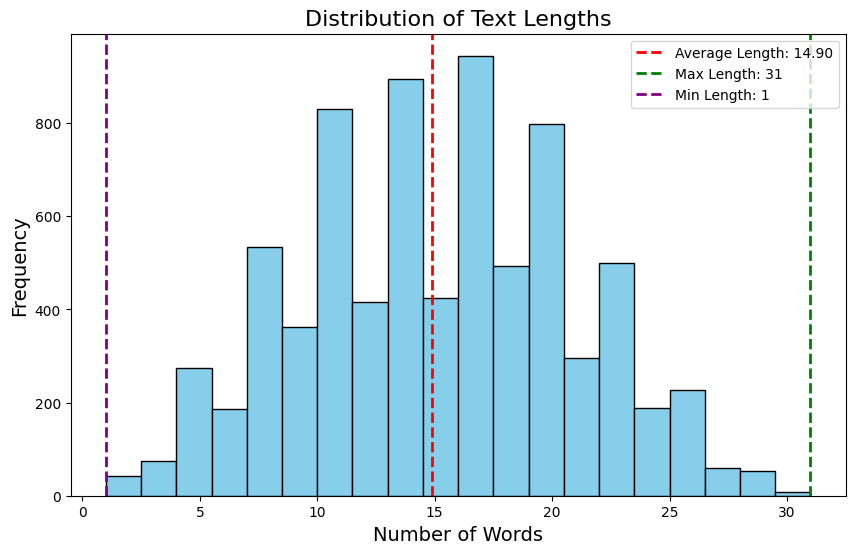

In [84]:
text_lengths = [len(str(text).split()) for text in df['text']]
max_length = max(text_lengths)
min_length = min(text_lengths)
average_length = np.mean(text_lengths)
print(f"Max length: {max_length}")
print(f"Min length: {min_length}")
print(f"Average length: {average_length}")
print()
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Text Lengths", fontsize=16)
plt.xlabel("Number of Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.axvline(average_length, color='red', linestyle='dashed', linewidth=2, label=f'Average Length: {average_length:.2f}')
plt.axvline(max_length, color='green', linestyle='dashed', linewidth=2, label=f'Max Length: {max_length}')
plt.axvline(min_length, color='purple', linestyle='dashed', linewidth=2, label=f'Min Length: {min_length}')
plt.legend()
plt.show()

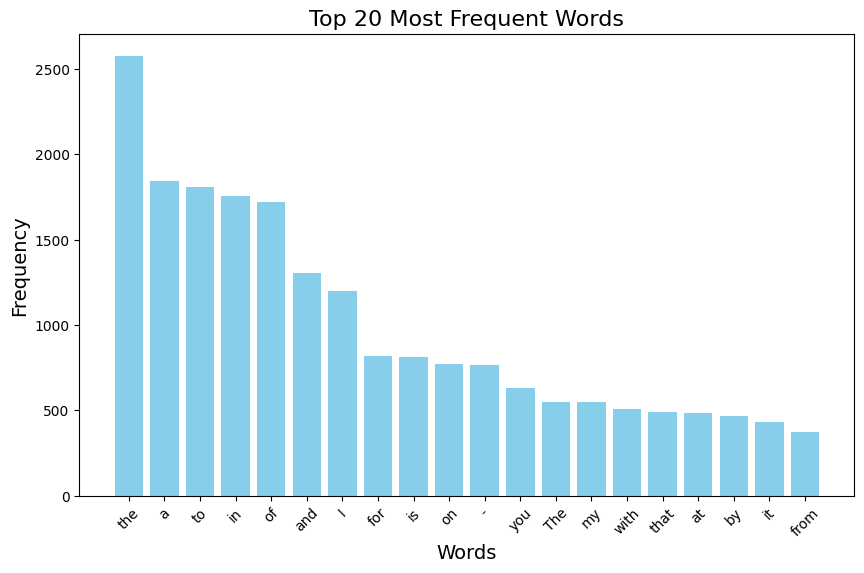

In [85]:
all_words = [word for text in df['text'] for word in str(text).split()]
word_freq = Counter(all_words)
top_10_words = word_freq.most_common(20)
words, counts = zip(*top_10_words)
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.title("Top 20 Most Frequent Words", fontsize=16)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45)
plt.show()

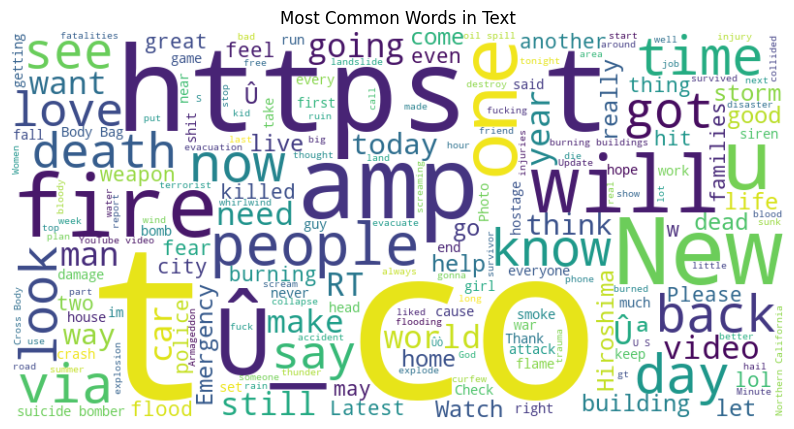

In [86]:
all_text = ' '.join(df['text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Text')
plt.show()

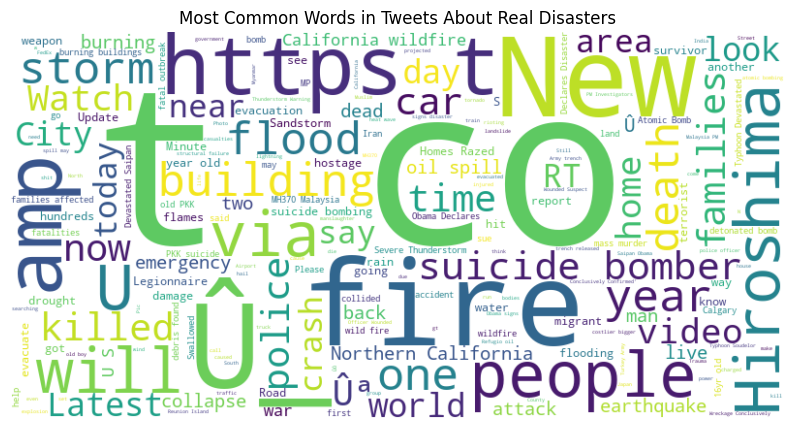

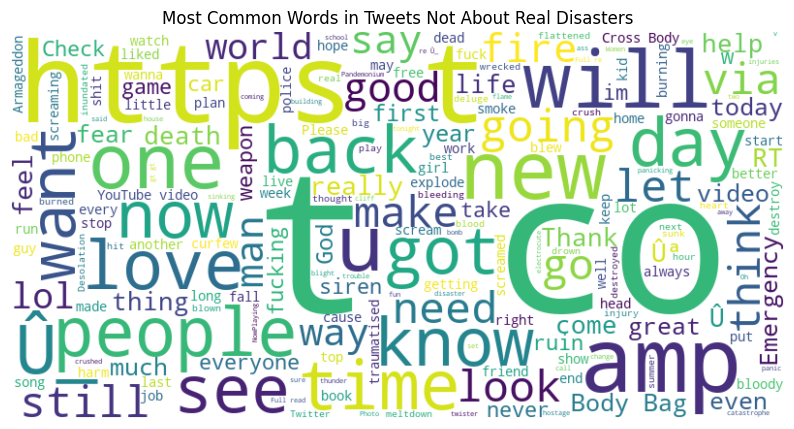

In [87]:
for label in df['target'].unique():
    label_text = ' '.join(df[df['target'] == label]['text'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(label_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if label == 1:
        plt.title('Most Common Words in Tweets About Real Disasters')
    else:
        plt.title('Most Common Words in Tweets Not About Real Disasters')
    plt.show()
    print()


# ***3. DATASET PREPROCESSING***

### **3.1. REMOVING UNNECESSARY COLUMNS & DROPPING ROWS WITH NULL VALUES**

In [88]:
df = df[['text','target']]
df = df.dropna(subset=['target'])
df = df.dropna(subset=['text'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


### **3.2. CLEANING DATA**

In [89]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

df['text'] = df['text'].apply(clean_text)
df.head()

,text,target
0,our deeds are the reason of this #earthquake m...,1
1,forest fire near la ronge sask. canada,1
2,all residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,just got sent this photo from ruby #alaska as ...,1


### **3.3. FEATURE ENGINEERING**

In [90]:
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

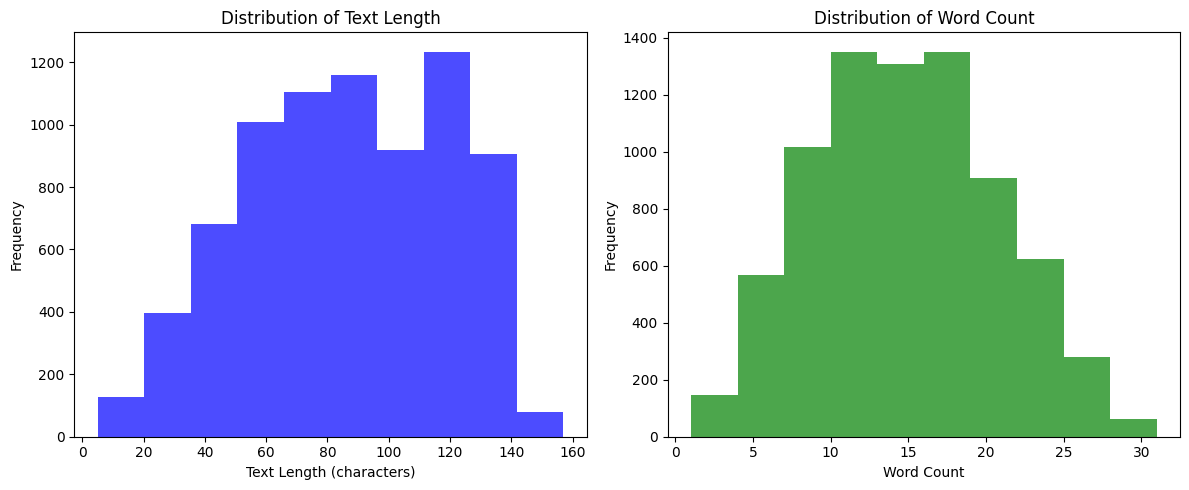

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting text length
axs[0].hist(df['text_length'], bins=10, color='blue', alpha=0.7)
axs[0].set_title('Distribution of Text Length')
axs[0].set_xlabel('Text Length (characters)')
axs[0].set_ylabel('Frequency')

# Plotting word count
axs[1].hist(df['word_count'], bins=10, color='green', alpha=0.7)
axs[1].set_title('Distribution of Word Count')
axs[1].set_xlabel('Word Count')
axs[1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### **3.4. SPLITTING THE DATASET**

In [92]:
X = df[['text', 'text_length', 'word_count']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (6851, 3) (6851,)
Testing set shape: (762, 3) (762,)


### **3.5. OVER-SAMPLING**

In [93]:
y_train.value_counts()

target
0    3916
1    2935
Name: count, dtype: int64

In [94]:
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
print("Original training set shape:", X_train.shape, y_train.shape)
print("Resampled training set shape:", X_train_resampled.shape, y_train_resampled.shape)
y_train_resampled.value_counts()

Original training set shape: (6851, 3) (6851,)
Resampled training set shape: (7832, 3) (7832,)


target
0    3916
1    3916
Name: count, dtype: int64

# ***4. TOKENIZATION AND EMBEDDING***

In [95]:
max_char_length = X_train_resampled['text'].str.len().max()
all_words = ' '.join(X_train_resampled['text']).split()
unique_words = set(all_words)
num_unique_words = len(unique_words)

print(f"Number of unique words in X_train: {num_unique_words}")
print(f"Maximum character length in X_train: {max_char_length}")


Number of unique words in X_train: 21744
Maximum character length in X_train: 157


In [96]:
all_words = ' '.join(X_train_resampled['text']).split()
tokenizer = nltk.FreqDist(all_words)
word_counts = tokenizer.items()
sorted_word_counts = sorted(word_counts, key=lambda x: x[1], reverse=True)
total_words = sum([count for _, count in sorted_word_counts])
cumulative_count = np.cumsum([count for _, count in sorted_word_counts])
cumulative_percentage = cumulative_count / total_words * 100
vocab_90 = np.argmax(cumulative_percentage >= 90) + 1
vocab_95 = np.argmax(cumulative_percentage >= 95) + 1
print(f"90% coverage vocab size: {vocab_90}")
print(f"95% coverage vocab size: {vocab_95}")

90% coverage vocab size: 10529
95% coverage vocab size: 16137


In [97]:
max_len = 150
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
vocab_size = 10000
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(X_train_resampled['text'])
word_index = tokenizer.word_index
total_words = len(word_index)
print(total_words)

16959


In [98]:
X_train, X_val, y_train, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.10, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Training set shape: (7048, 3) (7048,)
Validation set shape: (784, 3) (784,)


In [99]:
training_sequences = tokenizer.texts_to_sequences(X_train_resampled['text'])
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)
testing_sequences = tokenizer.texts_to_sequences(X_test['text'])
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)
validation_sequences = tokenizer.texts_to_sequences(X_val['text'])
validation_padded = pad_sequences(validation_sequences,
                                  maxlen = max_len,
                                  padding = padding_type,
                                  truncating = trunc_type)

In [100]:
def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_path = 'glove.6B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_path)

In [101]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# ***5. MODELS TRAINING***

### **5.1. RNN (RECURRENT NEURAL NETWORK)**

In [102]:
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
rnn_model.add(tf.keras.layers.SimpleRNN(128))
rnn_model.add(Dense(1, activation='sigmoid'))
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
rnn_model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
rnn_model.build(input_shape=(None, max_len))
rnn_model.summary()

d:\Projects\CSE440 NLP\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 150, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,055,041 (11.65 MB)

 Trainable params: 55,041 (215.00 KB)

 Non-trainable params: 3,000,000 (11.44 MB)

In [36]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              min_lr=1e-6)
history_rnn = rnn_model.fit(training_padded,
                    y_train_resampled,
                    epochs=50,
                    batch_size=32,
                    validation_data=(validation_padded, y_val),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5757 - loss: 0.6721 - val_accuracy: 0.7041 - val_loss: 0.5925 - learning_rate: 3.0000e-05
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7064 - loss: 0.5897 - val_accuracy: 0.7360 - val_loss: 0.5539 - learning_rate: 3.0000e-05
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7414 - loss: 0.5505 - val_accuracy: 0.7551 - val_loss: 0.5342 - learning_rate: 3.0000e-05
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7436 - loss: 0.5379 - val_accuracy: 0.7411 - val_loss: 0.5326 - learning_rate: 3.0000e-05
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7526 - loss: 0.5301 - val_accuracy: 0.7844 - val_loss: 0.5029 - learning_rate: 3.0000e-05
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7794 - loss: 0.5017 - val_accuracy: 0.7895 - val_loss: 0.4951 - learning_rate: 3.0000e-05
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc

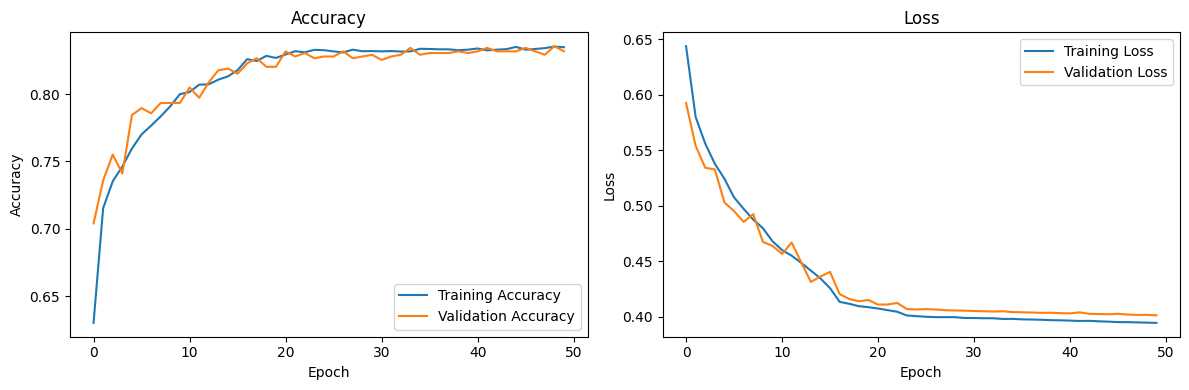

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(history_rnn.history['accuracy'], label='Training Accuracy')
ax1.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history_rnn.history['loss'], label='Training Loss')
ax2.plot(history_rnn.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [38]:
y_pred = rnn_model.predict(testing_padded)
y_pred_classes = (y_pred > 0.5).astype(int)

print("Test F1-Score:", rnn_model.evaluate(testing_padded, y_test)[1])

print(classification_report(y_test, y_pred_classes))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7811 - loss: 0.4879
Test F1-Score: 0.7834645509719849
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       426
           1       0.76      0.74      0.75       336

    accuracy                           0.78       762
   macro avg       0.78      0.78      0.78       762
weighted avg       0.78      0.78      0.78       762



### **5.2. GRU (Gated recurrent units)**

In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
bigru = Sequential()
bigru.add(Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
bigru.add(Bidirectional(GRU(128, return_sequences=True, kernel_regularizer=l2(0.01))))
bigru.add(Dropout(0.2))
bigru.add(Bidirectional(GRU(64, return_sequences=False, kernel_regularizer=l2(0.01))))
bigru.add(Dropout(0.2))
bigru.add(Dense(1, activation='sigmoid'))
bigru.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
bigru.build(input_shape=(None, max_len))
bigru.summary()

d:\Projects\CSE440 NLP\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 150, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 150, 256)       │       330,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,017 (13.18 MB)

 Trainable params: 454,017 (1.73 MB)

 Non-trainable params: 3,000,000 (11.44 MB)

In [41]:
num_epochs = 50
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              min_lr=1e-6)
history = bigru.fit(training_padded,
                     y_train_resampled,
                     epochs = num_epochs,
                     validation_data = (validation_padded, y_val),
                     batch_size=32,
                     callbacks = [early_stopping, reduce_lr])

Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - accuracy: 0.7185 - loss: 6.3586 - val_accuracy: 0.8074 - val_loss: 0.8062 - learning_rate: 5.0000e-04
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 31s 128ms/step - accuracy: 0.7971 - loss: 0.6833 - val_accuracy: 0.8125 - val_loss: 0.5987 - learning_rate: 5.0000e-04
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.8090 - loss: 0.5812 - val_accuracy: 0.8087 - val_loss: 0.5222 - learning_rate: 5.0000e-04
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.8023 - loss: 0.5297 - val_accuracy: 0.8151 - val_loss: 0.4942 - learning_rate: 5.0000e-04
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.8054 - loss: 0.5119 - val_accuracy: 0.8151 - val_loss: 0.4816 - learning_rate: 5.0000e-04
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.8099 - loss: 0.4869 - val_accuracy: 0.8112 - val_loss: 0.4677 - learning_rate: 5.0000e-04
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 31s 12

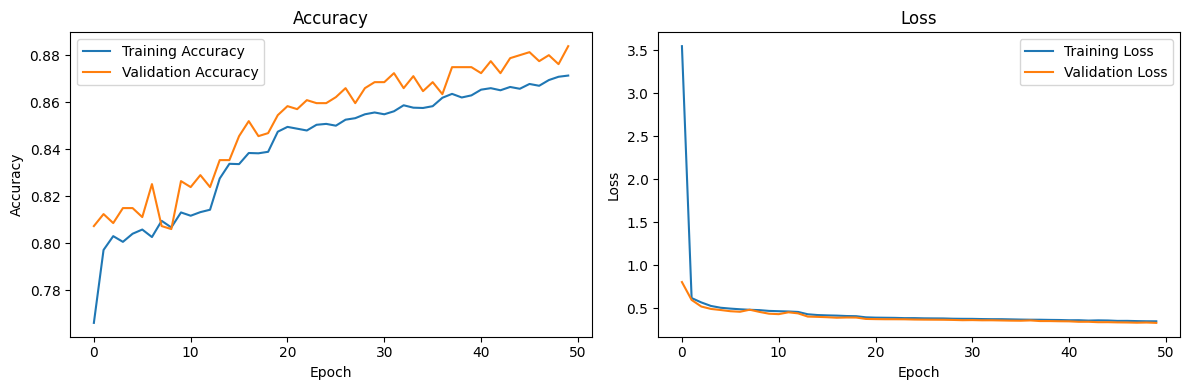

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [43]:
y_val_pred = bigru.predict(validation_padded)
y_val_pred = np.where(y_val_pred > 0.5, 1, 0)
print(f1_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
0.8794701986754967
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       390
           1       0.92      0.84      0.88       394

    accuracy                           0.88       784
   macro avg       0.89      0.88      0.88       784
weighted avg       0.89      0.88      0.88       784



### **5.3. Bi-LSTM (Bidirectional Long Short Term Memory)**

In [105]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
bilstm = Sequential()
bilstm.add(Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
bilstm.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))))
bilstm.add(Dropout(0.2))
bilstm.add(Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01))))
bilstm.add(Dropout(0.2))
bilstm.add(Dense(1, activation='sigmoid'))
bilstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
bilstm.build(training_padded.shape)
bilstm.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (7832, 150, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (7832, 150, 256)       │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (7832, 150, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (7832, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (7832, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (7832, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,603,777 (13.75 MB)

 Trainable params: 603,777 (2.30 MB)

 Non-trainable params: 3,000,000 (11.44 MB)

In [106]:
num_epochs = 50
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              min_lr=1e-6)
history = bilstm.fit(training_padded,
                     y_train_resampled,
                     epochs = num_epochs,
                     validation_data = (validation_padded, y_val),
                     batch_size=32,
                     callbacks = [early_stop, reduce_lr])

Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 42s 148ms/step - accuracy: 0.6680 - loss: 11.2378 - val_accuracy: 0.7844 - val_loss: 6.3524 - learning_rate: 1.0000e-04
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - accuracy: 0.7936 - loss: 5.3976 - val_accuracy: 0.7691 - val_loss: 3.2871 - learning_rate: 1.0000e-04
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 36s 146ms/step - accuracy: 0.7942 - loss: 2.8111 - val_accuracy: 0.8074 - val_loss: 1.8266 - learning_rate: 1.0000e-04
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - accuracy: 0.8170 - loss: 1.5942 - val_accuracy: 0.7934 - val_loss: 1.1824 - learning_rate: 1.0000e-04
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - accuracy: 0.8114 - loss: 1.0538 - val_accuracy: 0.8023 - val_loss: 0.8723 - learning_rate: 1.0000e-04
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 32s 132ms/step - accuracy: 0.8109 - loss: 0.8111 - val_accuracy: 0.8099 - val_loss: 0.7351 - learning_rate: 1.0000e-04
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 36s 1

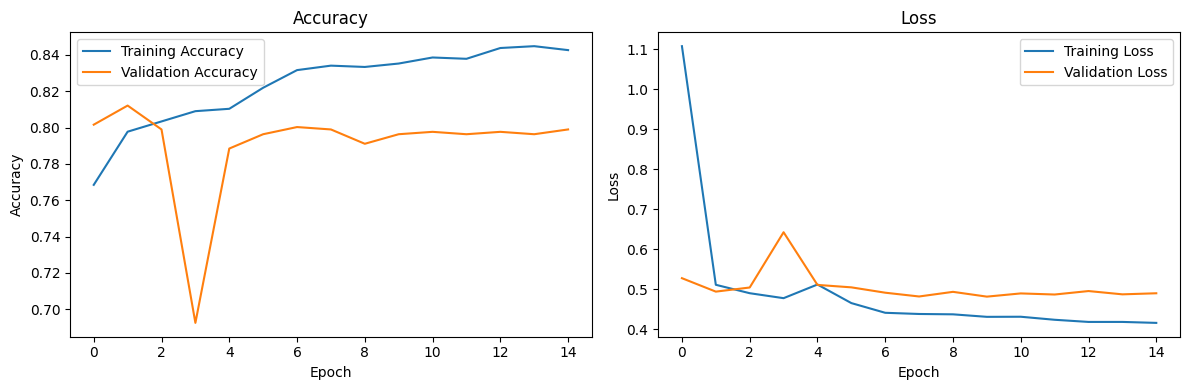

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_val_pred = bilstm.predict(validation_padded)
y_val_pred = np.where(y_val_pred > 0.5, 1, 0)
print(f1_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

24/24 [==============================] - 2s 14ms/step
0.752
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       431
           1       0.80      0.71      0.75       330

    accuracy                           0.80       761
   macro avg       0.80      0.79      0.79       761
weighted avg       0.80      0.80      0.79       761



### **5.4. Transformer (Albert)**

reference : 1. https://app.datacamp.com/learn/courses/introduction-to-deep-learning-with-pytorch

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

In [72]:
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2", clean_up_tokenization_spaces=False)
config = AlbertConfig(
    vocab_size=10000,
    embedding_size=512,  
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    max_position_embeddings=512,
    num_labels=2,
    hidden_dropout_prob=0.2,  
    attention_probs_dropout_prob=0.2
)
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)

def tokenize_texts(texts):
    return tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt", max_length=150)

train_inputs = tokenize_texts(X_train['text'])
val_inputs = tokenize_texts(X_val['text'])
test_inputs = tokenize_texts(X_test['text'])

y_train = torch.tensor(y_train.values)
y_val = torch.tensor(y_val.values)
y_test = torch.tensor(y_test.values)

train_dataset = TensorDataset(train_inputs["input_ids"], train_inputs["attention_mask"], y_train)
val_dataset = TensorDataset(val_inputs["input_ids"], val_inputs["attention_mask"], y_val)
test_dataset = TensorDataset(test_inputs["input_ids"], test_inputs["attention_mask"], y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# Define the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 10
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
# Training loop
model.to(device)
model.train()
for epoch in range(num_epochs):  # Adjust the number of epochs as needed
    c=0
    total_loss = 0
    for batch in train_dataloader:
        c+=1
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() #set gradiants to 0
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels) #run farward pass
        loss = outputs.loss #compute loss
        loss.backward() #backpropagation
        optimizer.step() #update parameters
        total_loss += loss.item()
        print(f"Epoch {epoch + 1} - Batch ({c}/{len(train_dataloader)}) - Loss: {loss.item()}")
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1} - Average Training Loss: {avg_train_loss:.4f}")
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    model.train()




Epoch 1 - Batch (1/221) - Loss: 0.750084400177002
Epoch 1 - Batch (2/221) - Loss: 0.7022977471351624
Epoch 1 - Batch (3/221) - Loss: 0.6429015398025513
Epoch 1 - Batch (4/221) - Loss: 0.7324711680412292
Epoch 1 - Batch (5/221) - Loss: 0.6826802492141724
Epoch 1 - Batch (6/221) - Loss: 0.6691516637802124
Epoch 1 - Batch (7/221) - Loss: 0.6188372373580933
Epoch 1 - Batch (8/221) - Loss: 0.5853604078292847
Epoch 1 - Batch (9/221) - Loss: 0.6795037984848022
Epoch 1 - Batch (10/221) - Loss: 0.5608139038085938
Epoch 1 - Batch (11/221) - Loss: 0.6083258390426636
Epoch 1 - Batch (12/221) - Loss: 0.5766518115997314
Epoch 1 - Batch (13/221) - Loss: 0.5837300419807434
Epoch 1 - Batch (14/221) - Loss: 0.8102703094482422
Epoch 1 - Batch (15/221) - Loss: 0.5971283316612244
Epoch 1 - Batch (16/221) - Loss: 0.6215129494667053
Epoch 1 - Batch (17/221) - Loss: 0.4828011393547058
Epoch 1 - Batch (18/221) - Loss: 0.5693351626396179
Epoch 1 - Batch (19/221) - Loss: 0.5730746984481812
Epoch 1 - Batch (20/22

In [42]:
model.eval()
total_test_loss = 0
correct_predictions = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_test_loss += loss.item()
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


avg_test_loss = total_test_loss / len(test_dataloader)
test_accuracy = correct_predictions / len(y_test)
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.8465, Test Accuracy: 0.7730


# ***6. EVALUATION***

In [ ]:
def compute_metrics(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# RNN model evaluation
y_pred_rnn = (rnn_model.predict(testing_padded) > 0.5).astype(int)
rnn_metrics = compute_metrics(y_test, y_pred_rnn)
print("RNN Metrics:", rnn_metrics)

# Bi-GRU model evaluation
y_pred_bigru = (bigru.predict(testing_padded) > 0.5).astype(int)
bigru_metrics = compute_metrics(y_test, y_pred_bigru)
print("Bi-GRU Metrics:", bigru_metrics)

# Bi-LSTM model evaluation
y_pred_bilstm = (bilstm.predict(testing_padded) > 0.5).astype(int)
bilstm_metrics = compute_metrics(y_test, y_pred_bilstm)
print("Bi-LSTM Metrics:", bilstm_metrics)

# Albert model evaluation
transformer_metrics = compute_metrics(y_test, all_predictions)
print("Transformer Metrics:", transformer_metrics)


In [ ]:
def plot_evaluation_metrics(y_true, y_pred_probs, model_name):
  y_pred_probs = np.array(y_pred_probs)
  y_pred = (y_pred_probs > 0.5).astype(int)

  # Confusion Matrix
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(10, 4))
  plt.subplot(1, 3, 1)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title(f'Confusion Matrix - {model_name}')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')

  # ROC Curve
  fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
  roc_auc = auc(fpr, tpr)
  plt.subplot(1, 3, 2)
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve - {model_name}')
  plt.legend(loc="lower right")

  # Precision-Recall Curve
  precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)
  plt.subplot(1, 3, 3)
  plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall Curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(f'Precision-Recall Curve - {model_name}')
  plt.legend(loc="lower left")

  plt.tight_layout()
  plt.show()

# RNN Model
plot_evaluation_metrics(y_test, y_pred_rnn, 'RNN')

# Bi-GRU Model
plot_evaluation_metrics(y_test, y_pred_bigru, 'Bi-GRU')

# Bi-LSTM Model
plot_evaluation_metrics(y_test, y_pred_bilstm, 'Bi-LSTM')

# Transformer Model
plot_evaluation_metrics(y_test, all_predictions, 'Transformer')


In [ ]:
# Models and metrics
models = ['RNN', 'Bi-GRU', 'Bi-LSTM', 'Transformer']
metrics = ['accuracy', 'precision', 'recall', 'f1']
data = [
    [rnn_metrics[m] for m in metrics],
    [bigru_metrics[m] for m in metrics],
    [bilstm_metrics[m] for m in metrics],
    [transformer_metrics[m] for m in metrics]
]

data = np.array(data)
x = np.arange(len(metrics))
width = 0.2 

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - 1.5*width, data[0], width, label='RNN')
ax.bar(x - 0.5*width, data[1], width, label='Bi-GRU')
ax.bar(x + 0.5*width, data[2], width, label='Bi-LSTM')
ax.bar(x + 1.5*width, data[3], width, label='Transformer')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.tight_layout()
plt.show()